# SVBench

## Load reference calls

This notebook will demonstrate how svbench can be used to benchmark SV calls using the HG002 sample.
We will use a reference call set from GIAB: [HG002](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_SVs_Integration_v0.6/HG002_SVs_Tier1_v0.6.vcf.gz)
We will analyse qurty calls made using the variant callers dysgu, manta and delly. These callers were run on the HG002 sample sequenced using Illumina 148bp paired-end reads at 40X coverage. 
For convenience, we will utilize an input folder `"../svbench_demo"` and place reference and query SV calls there. 

The first step is to load the reference calls into a CallSet object. CallSet objects are labelled with a dataset name, in this case "HG002". The load_vcf function parses the reference file using the pyvcf library and stores the result in a pandas dataframe. Input columns of interest can be selectively parsed, in this example we are selecting to keep the "FILTER" column from the input file. The 'other_cols' parameter can take a list of columns to parse from the input file. These can be specified in string format, or using svb.Col object (more on this below). If you want all the data in the vcf file to be parsed into the dataframe, `other_cols="all"` can be used.

In [20]:
import svbench as svb
from svbench import CallSet, Col
import pandas as pd


# Input is in vcf format, but bed and bedpe are also possible
hg002 = CallSet(dataset="HG002").\
            load_vcf("../svbench_demo/HG002_SVs_Tier1_v0.6.vcf.gz", other_cols=["FILTER"])



dataset=HG002, caller=None, loaded rows: 74012
columns: ['chrom', 'start', 'chrom2', 'end', 'svtype', 'w', 'id', 'size_filter_pass', 'svlen', 'GT', 'FILTER']
n not in include: 0


The pandas dataframe can be accessed using the 'breaks_df' attribute, for example:

In [2]:
hg002.breaks_df.head()

,chrom,start,chrom2,end,svtype,w,id,size_filter_pass,svlen,GT,FILTER
0,chr1,10403,chr1,10440,DEL,None,HG2_Ill_svaba_2,True,37,./.,[LongReadHomRef]
1,chr1,10415,chr1,10440,DEL,None,HG3_Ill_GATKHC_3,True,25,./.,[LongReadHomRef]
2,chr1,10616,chr1,10637,DEL,None,HG4_Ill_GATKHC_3,True,21,./.,[NoConsensusGT]
3,chr1,54712,chr1,54712,INS,None,HG2_Ill_250bpfermikitraw_2,True,53,./.,[NoConsensusGT]
4,chr1,385977,chr1,385977,INS,None,HG2_PB_PB10Xdip_2154,True,74,./.,[NoConsensusGT]


As a side note, svbench `CallSet` objects are pickle friendly, which can save time when parsing input files: 

In [5]:
import pickle
import time

t0 = time.time()
hg002 = CallSet(dataset="HG002").\
            load_vcf("../svbench_demo/HG002_SVs_Tier1_v0.6.vcf.gz", other_cols=["FILTER"])
print(time.time() - t0)

pickle.dump(hg002, open("../svbench_demo/hg002.pkl", "wb"))

t0 = time.time()
hg002 = pickle.load(open("../svbench_demo/hg002.pkl", "rb"))
print(time.time() - t0)

dataset=HG002, caller=None, loaded rows: 74012
columns: ['chrom', 'start', 'chrom2', 'end', 'svtype', 'w', 'id', 'size_filter_pass', 'svlen', 'GT', 'FILTER']
n not in include: 0


14.270062685012817
0.28818583488464355


The HG002 reference set can be split into different tiers, with Tier1 calls representing the highest quality/most confident genomic regions. In this example we will select the
Tier1+2 regions using the bed file provided by GIAB [link is here](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_SVs_Integration_v0.6/HG002_SVs_Tier1plusTier2_v0.6.1.bed)

The reference calls can be filtered using the `filter_include_bed` function:

In [6]:
tier1_2 = hg002.filter_include_bed("../svbench_demo/HG002_SVs_Tier1plusTier2_v0.6.1.bed")

dataset=None, caller=None, loaded rows: 23901
Filtered by include_bed, caller=None, dataset=HG002 rows before 74012, after 40742


Finally we will add intervals around each break point, this is needed when comparing query calls to this reference set. Here we add 250 bp intervals around each break point. Also note, adding intervals should only be done once all filtering steps have been performed, as filtering can invalidate the added intervals:

In [7]:
tier1_2 = tier1_2.add_intervals(slop=250)

## Load query calls

Next we will load calls made using dysgu, manta and delly. For convenience there are loading functions for some of the popular structural variant callers. However, query vcf files are parsed in the same way as the reference calls, so a custom loading function can also be written:

In [22]:
from svbench import load_dysgu, load_manta, load_delly

dysgu = load_dysgu("../svbench_demo/HG002.dysgu.v1.2.6.vcf", dataset="HG002")
manta = load_manta("../svbench_demo/HG002.manta.diploidSV.vcf", dataset="HG002")
delly = load_delly("../svbench_demo/HG002.delly.vcf", dataset="HG002")

Loading dysgu, stratified using svbench.Col(add=None col=FORMAT, key=PROB, encoding=None, bins=[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ], norm=None, op=None, thresh=None), keep records with svbench.Col(add=None col=FILTER, key=None, encoding=None, bins=None, norm=None, op=eq, thresh=None)
dataset=HG002, caller=dysgu, loaded rows: 17878
columns: ['chrom', 'start', 'chrom2', 'end', 'svtype', 'w', 'strata', 'id', 'size_filter_pass', 'svlen', 'GT']
n not in include: 0
Loading manta, stratified using svbench.Col(add=None col=QUAL, key=None, encoding=None, bins=range(0, 1500, 50), norm=None, op=None, thresh=None), keep records with svbench.Col(add=None col=FILTER, key=None, encoding=None, bins=None, norm=None, op=eq, thresh=None)
dataset=HG002, caller=manta, loaded rows: 8436
columns: [

### Manually loading a vcf file
To demonstrate how the default loading options can be changed, or to load a new file from a novel caller, we will re-load the calls from delly using the `load_vcf` function:

In [9]:

delly_v2 = CallSet(dataset="HG002", caller="delly_DP").\
            load_vcf("../svbench_demo/HG002.delly.vcf",
                     stratify=Col("FORMAT", "DP", bins=range(0, 100, 2)),
                     keep=[Col("FILTER", op="eq", thresh=None)])

dataset=HG002, caller=delly_DP, loaded rows: 14498
columns: ['chrom', 'start', 'chrom2', 'end', 'svtype', 'w', 'strata', 'id', 'size_filter_pass', 'svlen', 'GT']
n not in include: 0


The main difference compared with loading the reference calls, is that `stratify` and `keep` arguments are used. The `stratify` argument tells svbench how to bin variants into different strata which is needed for plotting a precison-recall curve. This is achived by using a `Col` object:

In [7]:
Col("FORMAT", "DP", bins=range(0, 100, 2))

svbench.Col(add=None col=FORMAT, key=DP, encoding=None, bins=range(0, 100, 2), norm=None, op=None, thresh=None)

This specifies that in the `"FORMAT"` field, the `"DP"` column will be used, and the bin values will be `bins=range(0, 100, 2))`. Likewise input calls are also filtered during loading by using the `keep` argument:

In [8]:
Col("FILTER", op="eq", thresh=None)

svbench.Col(add=None col=FILTER, key=None, encoding=None, bins=None, norm=None, op=eq, thresh=None)

Here only records without a filter applied will be loaded. The `op="eq"` argument will apply a test of equality with `thresh=None`. For example, another option might be to filter calls with `DP` > 3 reads, this could be achived using `keep=Col("FORMAT", "DP", op="gt", thresh=3)` 

## Manually filtering a CallSet 
Vcf records are converted to a pandas DataFrame internally. The DataFrame can be accessed using:

In [10]:
delly.breaks_df

,chrom,start,chrom2,end,svtype,w,strata,id,size_filter_pass,svlen,GT
0,chrM,2,chrM,16202,DUP,None,10000.0,DUP00000000,True,16200,0/1
1,chrM,10266,chrM,10649,INV,None,88.0,INV00000009,True,383,0/0
2,chrM,12868,chrM,14978,INV,None,544.0,INV00000012,True,2110,0/0
3,chrM,13442,chrM,15488,INV,None,161.0,INV00000013,True,2046,0/0
4,chrM,14300,chrM,14540,DEL,None,81.0,DEL00000014,True,240,0/0
...,...,...,...,...,...,...,...,...,...,...,...
14493,chrUn_gl000234,37525,chrUn_gl000234,37765,DEL,None,762.0,DEL00046232,True,240,0/1
14494,chrUn_gl000236,6330,chrUn_gl000236,6366,DEL,None,237.0,DEL00046248,True,36,0/1
14495,chrUn_gl000237,9046,chrUn_gl000237,9079,DEL,None,845.0,DEL00046257,True,33,0/1
14496,chrUn_gl000239,27550,chrUn_gl000239,27991,DUP,None,569.0,DUP00046262,True,441,0/0


Svbench supports a thin wrapper around the pandas DataFrame [query](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html) function. For example, we can filter for deletion calls > 300 bp:

In [11]:
delly_v2 = delly_v2.query("svtype.str.match('DEL') and svlen>=300")

Filtered by expression, caller=delly_DP, dataset=HG002 rows before 14498, after 3477


## Comparing query vs reference calls
First we will put our query calls in a list. Then we will filter query calls that overlap Tier1+2 regions, as we did your the reference calls:

In [23]:
callers = [dysgu, manta, delly]
callers_tier1_2 = [i.filter_include_bed("../svbench_demo/HG002_SVs_Tier1plusTier2_v0.6.1.bed", inplace=False) 
           for i in callers]
#for c in callers:
#    c.filter_include_bed("../svbench_demo/HG002_SVs_Tier1plusTier2_v0.6.1.bed", inplace=True)

dataset=None, caller=None, loaded rows: 23901
Filtered by include_bed, caller=dysgu, dataset=HG002 rows before 17878, after 10858
dataset=None, caller=None, loaded rows: 23901
Filtered by include_bed, caller=manta, dataset=HG002 rows before 8436, after 7390
dataset=None, caller=None, loaded rows: 23901
Filtered by include_bed, caller=delly, dataset=HG002 rows before 14498, after 6270


Next query calls are compared to a reference set using the `score` function. The `score` function can accept `CallSet`, or a `list` of `CallSet`, in the form `score(reference_calls, query_calls)`. The score function will print out summary statistics and result tables will also be appended to input query `CallSet`'s. Internally, the `score` function matches the `dataset` attributes of the reference and query calls. 

In [24]:
svb.score(tier1_2, callers_tier1_2)

Scoring dataset=HG002 caller=dysgu
Score table caller=dysgu against dataset=HG002
Scores:
  Caller  T >=    Ref  Total    TP   FP  DTP     FN  Duplication  Precision  Recall      F1
0  dysgu  None  40742  10858  9994  635  229  30748     0.022914     0.9403  0.2453  0.3891
Scores over size ranges:
  Caller    Ref size ranges    TP   FP     FN  Precision    Recall        F1
0  dysgu           [30, 50)  1596   83   4590   0.950566  0.258002  0.405849
1  dysgu          [50, 500)  6440  348  14032   0.948733  0.314576  0.472487
2  dysgu        [500, 5000)  1290  187   3526   0.873392  0.267857  0.409979
3  dysgu  [5000, 260000000)   164   17    352   0.906077  0.317829  0.470588
4  dysgu         All ranges  9490  635  22500   0.937284  0.296655  0.450671
GT scores:
  Caller  GT_precision  GT_recall   GT_f1   0/1   1/1  0/0  ./.
0  dysgu      0.517314   0.154462  0.2379  8117  2615  124    2
---------------------------------------------
Scoring dataset=HG002 caller=manta
Score table caller=

The results can be interrogated in a few ways. Each query callset will have a `scores`, `size_scores` and `gt_scores` attributes filled out, which are pandas `DataFrame` tables:

In [25]:
dysgu_res = callers_tier1_2[0]
dysgu_res.scores

,Caller,T >=,Ref,Total,TP,FP,DTP,FN,Duplication,Precision,Recall,F1
0,dysgu,None,40742,10858,9994,635,229,30748,0.022914,0.9403,0.2453,0.3891


In [26]:
pd.concat([i.scores for i in callers_tier1_2])

,Caller,T >=,Ref,Total,TP,FP,DTP,FN,Duplication,Precision,Recall,F1
0,dysgu,None,40742,10858,9994,635,229,30748,0.022914,0.9403,0.2453,0.3891
0,manta,None,40742,7390,6827,368,195,33915,0.028563,0.9489,0.1676,0.2849
0,delly,None,40742,6270,4512,1720,38,36230,0.008422,0.7240,0.1107,0.1920


Alternatively records in the main DataFrame are labelled: 

In [27]:
dysgu_res.breaks_df.head()

,chrom,start,chrom2,end,svtype,w,strata,id,size_filter_pass,svlen,GT,TP,DTP,ref_index,FP,ref_size,ref_GT
0,chr1,54720,chr1,54720,INS,None,0.562,3,True,54,0/1,True,False,3.0,False,53.0,./.
1,chr1,66452,chr1,66452,INS,None,0.657,7,True,54,0/1,False,False,NaN,True,NaN,0/0
2,chr1,756259,chr1,756259,INS,None,0.692,32,True,434,0/1,True,False,10.0,False,244.0,./.
3,chr1,821604,chr1,821605,INS,None,0.609,46,True,30,0/1,True,False,17.0,False,30.0,./.
4,chr1,829171,chr1,829207,DEL,None,0.909,54,True,36,1/1,True,False,18.0,False,36.0,./.


Also the missing reference calls are given by a set of indexes, here we convert to a list and show the first 3 indexes:

In [28]:
fn = list(dysgu_res.false_negative_indexes)
fn[:3]

[2, 4, 6]

The corresponding reference calls can be collected using:

In [29]:
tier1_2.breaks_df.loc[dysgu_res.false_negative_indexes]

,chrom,start,chrom2,end,svtype,w,id,size_filter_pass,svlen,GT,FILTER
2,chr1,10616,chr1,10637,DEL,None,HG4_Ill_GATKHC_3,True,21,./.,[NoConsensusGT]
4,chr1,385977,chr1,385977,INS,None,HG2_PB_PB10Xdip_2154,True,74,./.,[NoConsensusGT]
6,chr1,532077,chr1,532177,DEL,None,HG2_PB_SVrefine2PB10Xhap12_3,True,100,./.,[NoConsensusGT]
8,chr1,645959,chr1,645959,INS,None,HG2_PB_PB10Xdip_2549,True,319,./.,[NoConsensusGT]
9,chr1,724861,chr1,724861,INS,None,HG2_Ill_breakscan11_2919,True,2358,./.,[NoConsensusGT]
...,...,...,...,...,...,...,...,...,...,...,...
74007,chrY,59002942,chrY,59002942,INS,None,HG4_PB_HySA_29505,True,61,./.,[NoConsensusGT]
74008,chrY,59004477,chrY,59004690,DEL,None,HG2_Ill_GATKHCSBGrefine_13224,True,213,./.,[NoConsensusGT]
74009,chrY,59013741,chrY,59013741,INS,None,HG3_PB_SVrefine2PBcRDovetail_10185,True,133,./.,[NoConsensusGT]
74010,chrY,59019531,chrY,59019553,DEL,None,HG2_Ill_scalpel_18829,True,22,./.,[NoConsensusGT]


## Plotting results
Svbench provides a function for plotting a precision vs true positive (TP) curve:

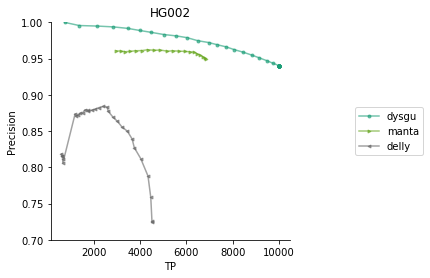

{'HG002': <module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>}

In [30]:
svb.plot(callers_tier1_2, ylim=(0.7, 1), x="TP", y="Precision")

Finally, we filter all input calls for insertions (All-regions) and plot the results. Note, the `add_intervals` function should be called again as the old intervals might be invalid:

In [36]:
callers = [dysgu, manta, delly]
callers = [i.filter_by_svtype("INS") for i in callers]
hg002 = hg002.filter_by_svtype("INS").add_intervals(slop=250)
svb.score(hg002, callers)

Filtered by svtype, caller=dysgu, dataset=HG002 rows before 17878, after 8227
Filtered by svtype, caller=manta, dataset=HG002 rows before 8436, after 2764
Filtered by svtype, caller=delly, dataset=HG002 rows before 14498, after 1748
Filtered by svtype, caller=None, dataset=HG002 rows before 36600, after 36600
Scoring dataset=HG002 caller=dysgu
Score table caller=dysgu against dataset=HG002
Scores:
  Caller  T >=    Ref  Total    TP   FP  DTP     FN  Duplication  Precision  Recall      F1
0  dysgu  None  36600   8227  7193  934  100  29407     0.013902     0.8851  0.1965  0.3216
Scores over size ranges:
  Caller    Ref size ranges    TP   FP     FN  Precision    Recall        F1
0  dysgu           [30, 50)  2848  199   4584   0.934690  0.383208  0.543563
1  dysgu          [50, 500)  3043  695   8817   0.814072  0.256577  0.390178
2  dysgu        [500, 5000)   557   40   2762   0.932998  0.167822  0.284474
3  dysgu  [5000, 260000000)     1    0    252   1.000000  0.003953  0.007874
4  dy

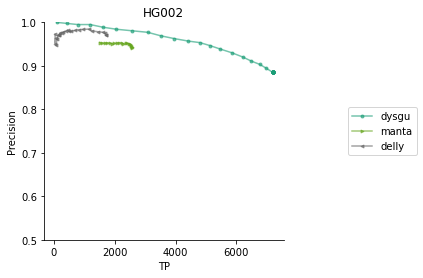

{'HG002': <module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>}

In [37]:
svb.plot(callers, ylim=(0.5, 1), x="TP", y="Precision")